In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
from timm.utils import AverageMeter
from sklearn.model_selection import KFold
from models.vgg import vgg

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:>

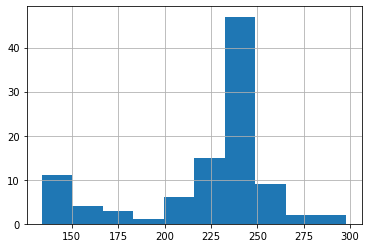

In [ ]:
data = pd.read_csv("/work/herbarium-2022/data/train_cultivar_mapping.csv")
data.cultivar.value_counts().hist()

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
from sklearn import preprocessing

class CultivarDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, )
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # one-hot encoding (very messy)
        self.onehotenc = preprocessing.OneHotEncoder()
        self.onehotenc.fit([[i] for i in self.img_labels['cultivar'].tolist()])

        # bablaba = self.onehotenc.transform([['PI_329299']]).toarray()
        # print(f'Size of one-hot column {len(bablaba[0])}')
    
    def to_onehot(self, lbl: str):
        return torch.from_numpy(self.onehotenc.transform([[lbl]]).toarray()[0])

    def __len__(self):
        # print(f'length: {len(self.img_labels)}')
        return len(self.img_labels)

    def __getitem__(self, idx):
        # print(f'sampling: {idx}')
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = read_image(img_path)
        label = self.to_onehot(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(image, label)
        return image, label

In [ ]:
import torchvision.transforms as T

# mean and std of each color channel
# below is that of imagenet 
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

training_data = CultivarDataset(
    annotations_file="data/train_cultivar_mapping.csv",
    img_dir="data/train_images",
    transform=T.Compose([
        T.RandomEqualize(p=1), # if only this can be done AFTER the crop
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomCrop(size=(500, 500)),
        T.RandomRotation(degrees=(-180, 180)),
        T.CenterCrop(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

Notes on Hyperparameter:
- https://arxiv.org/pdf/1803.09820.pdf
- Momentum is usually always 0.9

In [ ]:
# Hyperparameters
lr = 1e-3
momentum = 0.9
weight_decay = 1e-4
epoches = 100
k_fold = 10

In [ ]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def cultivar_train(model, data_loader_train, optimizer, criterion, epoch):
    model.train()
    optimizer.zero_grad()

    loss_meter = AverageMeter()

    with tqdm(enumerate(data_loader_train), total=len(data_loader_train)) as pbar:
        for idx, (samples, targets) in enumerate(data_loader_train):
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item(), target.size(0))
            pbar.set_description(f"Train epoch {epoch}, loss: {loss_meter.avg: .4f}")
    return loss_meter.avg

In [ ]:
def cultivar_val(model, data_loader_val, criterion, epoch):
    model.eval()
    loss_meter = AverageMeter()
    with tqdm(enumerate(data_loader_train), total=len(data_loader_train)) as pbar:
        for idx, (samples, targets) in enumerate(data_loader_val):
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            loss_meter.update(loss.item(), target.size(0))

            pbar.set_description(f"Validation epoch {epoch}, loss: {loss_meter.avg: .4f}")
    return loss_meter.avg

You need to run the `test.csv` and `train.csv` generation in `cultivardataset.ipynb` before running this!


The general procedure of k-fold is as follows:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

In [ ]:
# set_random_seed(seed=0)
print("Creating datasets...")
dataset = CultivarDataset(
    annotations_file="data/train_metadata_subset.csv",
    img_dir="data/train_images",
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomCrop(size=(500, 500)),
        T.RandomRotation(degrees=(-180, 180)),
        T.CenterCrop(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

# dataset_val = CultivarDataset(
#     annotations_file="data/test.csv",
#     img_dir="data/train_images",
#     transform=T.Compose([
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         # T.ColorJitter(brightness=.5, contrast=.7),
#         T.CenterCrop(size=(224, 224)),
#         T.Normalize(norm_mean, norm_std)
#     ])
# )

summary_writer = SummaryWriter()
k_min_loss = [float('inf')]*k_fold

kfold = KFold(n_splits=k_fold, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)


    print("Validation dataset created")
    data_loader_train = torch.utils.data.DataLoader(
        dataset,
        batch_size = 32,
        sampler = train_subsampler,
        shuffle = False,
        num_workers = 0,
        pin_memory = True,
        drop_last = True
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset,
        batch_size = 32,
        sampler = test_subsampler,
        shuffle = False,
        num_workers = 0,
        pin_memory = True,
        drop_last = False
    )

    print("Dataloader created")
    print("Creating model...")
    model = vgg("vgg19_bn", "E", 100, True, True)
    model.cuda()
    optimizer = optim.SGD(model.parameters(), momentum=momentum, nesterov=True, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    min_loss = float('inf')

    print("Start Training")
    for epoch in range(epoches):
        loss_train = cultivar_train(model, data_loader_train, optimizer, criterion, epoch)
        loss_val = cultivar_val(model, data_loader_val, criterion, epoch)
        min_loss = min(min_loss, loss_val)
        print("Writing to summarywriter...")
        summary_writer.add_scalar(f'Fold {fold}, loss/train', loss_train, epoch)
        summary_writer.add_scalar(f'Fold {fold}, loss/val', loss_val, epoch)
        summary_writer.add_scalar(f'Fold {fold}, min_loss', min_loss, epoch)
        if min_loss == loss_val:
            k_min_loss[fold] = min_loss

print(f"K fold cross validate min loss average {sum(k_min_loss)/len(k_min_loss)}")

Creating datasets...
FOLD 0
--------------------------------
Validation dataset created
Dataloader created
Creating model...
| Downloading ImageNet fine-tuned vgg19_bn...
Start Training
  0%|          | 0/4 [00:00<?, ?it/s]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>